In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib ipympl

In [35]:
# Read the CSV files
ft_sensor_data = pd.read_csv('ft_sensor_data_20251023_021626.csv')
psoc_data = pd.read_csv('20251029_195156__C__Users_Will_miniconda3_shell_condabin_conda-hook.ps1_____conda_activate_base__data.csv')

# Display basic information about the datasets
print("FT Sensor Data Info:")
print(ft_sensor_data.info())
print("\nFirst few rows of FT Sensor Data:")
print(ft_sensor_data.head())

# print("\nPSOC Data Info:")
# print(psoc_data.info())
# print("\nFirst few rows of PSOC Data:")
# print(psoc_data.head())
psoc_data

FT Sensor Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34500 entries, 0 to 34499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  34500 non-null  float64
 1   fx         34500 non-null  float64
 2   fy         34500 non-null  float64
 3   fz         34500 non-null  float64
 4   tx         34500 non-null  float64
 5   ty         34500 non-null  float64
 6   tz         34500 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB
None

First few rows of FT Sensor Data:
   timestamp        fx        fy        fz        tx        ty        tz
0  23.519599  0.004518 -0.009007  0.017876  0.000470 -0.000188 -0.000002
1  23.520598 -0.016964 -0.026268 -0.070142 -0.000712  0.000346 -0.000037
2  23.521598 -0.000815  0.015046  0.016088 -0.000005 -0.000156  0.000071
3  23.522599 -0.002626 -0.005877  0.033185  0.000164  0.000242  0.000158
4  23.523598 -0.003428 -0.006228  0.050814  0.000327  0.000351 -0.

,Value,Mode,Port,Timestamp Sent,Timestamp Received
0,126.0,0.0,0.0,55474.0,1.761786e+12
1,29.0,0.0,1.0,55310.0,1.761786e+12
2,29.0,0.0,2.0,55465.0,1.761786e+12
3,29.0,0.0,3.0,55903.0,1.761786e+12
4,29.0,0.0,4.0,55090.0,1.761786e+12
...,...,...,...,...,...
4218,29.0,1.0,5.0,56149.0,1.761786e+12
4219,29.0,1.0,6.0,56018.0,1.761786e+12
4220,29.0,1.0,7.0,56165.0,1.761786e+12
4221,126.0,0.0,0.0,55478.0,1.761786e+12


In [36]:
###################### pre-process PSOC data: ######################

#### fix the timestamps #############

# Identify the first column (assumed to be timestamps)
col0 = psoc_data.columns[0]

# Ensure numeric dtype
psoc_data[col0] = pd.to_numeric(psoc_data[col0], errors='coerce')

# Add 10000 to each negative element in the first column
psoc_data.loc[psoc_data[col0] < 0, col0] += 10000

# Accumulate the column in an "accumulation-esque" fashion (running sum)
psoc_data[col0] = psoc_data[col0].cumsum() / 10000 # 10 khz clock

##### Creating new Super Array #########

# Create an n x 17 array: column 0 = timestamp, columns 1-16 = channels (8*mode + pin)
n = len(psoc_data)
psoc_matrix = np.full((n, 17), np.nan, dtype=float)

# Fill timestamp column (already processed above)
psoc_matrix[:, 0] = psoc_data[col0].values 

# Assume the incoming columns are in positions 1 (mode), 2 (pin), 3 (value)
mode_col = psoc_data.columns[1]
pin_col = psoc_data.columns[2]
val_col  = psoc_data.columns[3]

# Convert to numeric arrays
modes = pd.to_numeric(psoc_data[mode_col], errors='coerce').to_numpy(dtype=float)
pins  = pd.to_numeric(psoc_data[pin_col],  errors='coerce').to_numpy(dtype=float)
vals  = pd.to_numeric(psoc_data[val_col],  errors='coerce').to_numpy(dtype=float)

# Compute channel indices and guard against invalid entries
indices = 8 * modes + pins  # expected range: 0..15
valid = np.isfinite(indices) & (indices >= 0) & (indices < 16) & np.isfinite(vals)

rows = np.nonzero(valid)[0]
cols = indices[valid].astype(int) + 1  # +1 because column 0 is timestamp

# Populate matrix
psoc_matrix[rows, cols] = vals[valid]


# #### interpolation ##########

# Use pandas interpolate() column-wise (treat exact zeros as missing)
col_names = ['timestamp'] + [f'ch{i}' for i in range(1, 17)]
df_psoc = pd.DataFrame(psoc_matrix, columns=col_names)

# Treat exact 0.0 as missing for sensor columns (do not touch timestamp)
sensor_cols = col_names[1:]
df_psoc[sensor_cols] = df_psoc[sensor_cols].replace(0.0, np.nan)

# Interpolate column-wise. 'linear' uses row order; limit_area='inside' avoids extrapolation.
df_psoc.interpolate(method='linear', axis=0, limit_area='inside', inplace=True)

# Replace any remaining NaNs with 0.0 to keep the matrix numeric
df_psoc.fillna(0.0, inplace=True)



##### gets rid of first and last 16 samples #########
df_psoc = df_psoc.iloc[16:-16].reset_index(drop=True)
psoc_data = df_psoc.copy()
print(df_psoc.head(10))


   timestamp        ch1         ch2         ch3         ch4         ch5  \
0     0.0782  55471.000  55320.3125  55462.3750  55894.8750  55086.2500   
1     0.0811  55471.125  55321.0000  55462.1875  55894.2500  55085.9375   
2     0.0840  55471.250  55321.1875  55462.0000  55893.6250  55085.6250   
3     0.0869  55471.375  55321.3750  55462.6875  55893.0000  55085.3125   
4     0.0898  55471.500  55321.5625  55463.3750  55893.3125  55085.0000   
5     0.0927  55471.625  55321.7500  55464.0625  55893.6250  55084.8750   
6     0.0956  55471.750  55321.9375  55464.7500  55893.9375  55084.7500   
7     0.0984  55471.875  55322.1250  55465.4375  55894.2500  55084.6250   
8     0.1110  55472.000  55322.3125  55466.1250  55894.5625  55084.5000   
9     0.1139  55472.125  55322.5000  55466.8125  55894.8750  55084.3750   

          ch6         ch7         ch8         ch9        ch10        ch11  \
0  56152.0000  56006.7500  56141.6250  55469.5000  55312.3125  55463.6250   
1  56153.0000  56007

In [37]:

# Normalize timestamps by making them relative to start time
ft_start_time = ft_sensor_data['timestamp'].iloc[0]

# use the processed PSOC dataframe (df_psoc) which contains 'timestamp'

psoc_start_time = psoc_data['timestamp'].iloc[0]

# Modify the timestamp columns in place
ft_sensor_data['timestamp'] = ft_sensor_data['timestamp'] - ft_start_time
psoc_data['timestamp'] = (psoc_data['timestamp'] - psoc_start_time) - 0.400  # Add offset



In [38]:
# Negate all force and torque measurements from FT sensor
force_torque_columns = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']
ft_sensor_data[force_torque_columns] = -ft_sensor_data[force_torque_columns]

In [39]:
# Calculate durations
ft_duration = ft_sensor_data['timestamp'].iloc[-1] - ft_sensor_data['timestamp'].iloc[0]

# Calculate time step in PSOC data
psoc_duration = psoc_data['timestamp'].iloc[-1] - psoc_data['timestamp'].iloc[0]

print(f"FT Sensor Data duration: {ft_duration:.2f} seconds")
print(f"PSOC Data duration: {psoc_duration:.6f} seconds")
print(f"\nNumber of samples:")
print(f"FT Sensor Data: {len(ft_sensor_data)} samples")
print(f"PSOC Data: {len(psoc_data)} samples")


FT Sensor Data duration: 34.47 seconds
PSOC Data duration: 17.173600 seconds

Number of samples:
FT Sensor Data: 34500 samples
PSOC Data: 4191 samples


/tmp/nix-shell.BuT1HZ/ipykernel_11572/2172799827.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent label overlap


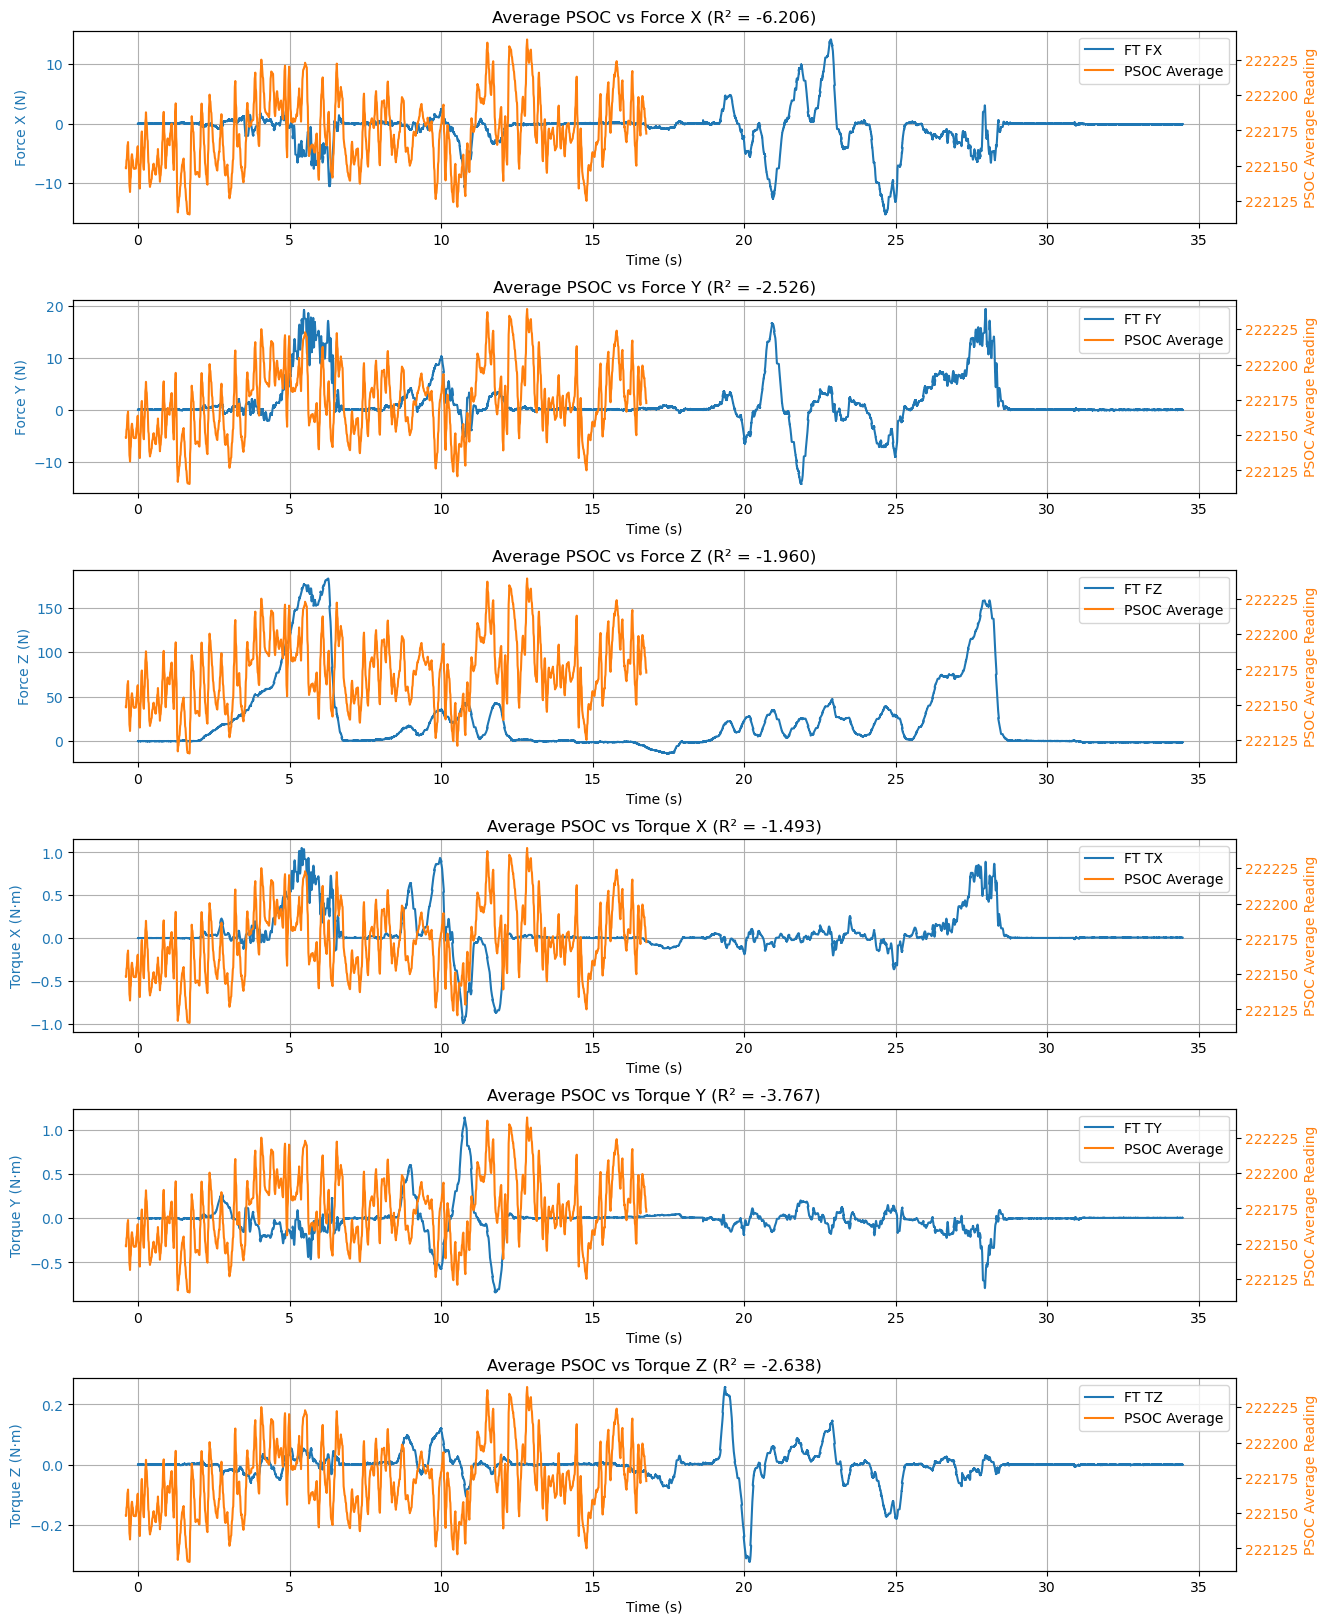

In [41]:
# Calculate average of c1normal through c4normal
avg_normal = psoc_data['ch1'] + psoc_data['ch2'] +psoc_data['ch3'] + psoc_data['ch4']

# Function to calculate R-squared
def calculate_r2(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Create figure with subplots for each force/torque measurement
fig = plt.figure(figsize=(15, 20))
gs = fig.add_gridspec(6, 1, hspace=0.4)

# Plot titles and data to plot
plot_data = [
    ('Average PSOC vs Force X', 'fx', 'Force X (N)'),
    ('Average PSOC vs Force Y', 'fy', 'Force Y (N)'),
    ('Average PSOC vs Force Z', 'fz', 'Force Z (N)'),
    ('Average PSOC vs Torque X', 'tx', 'Torque X (N⋅m)'),
    ('Average PSOC vs Torque Y', 'ty', 'Torque Y (N⋅m)'),
    ('Average PSOC vs Torque Z', 'tz', 'Torque Z (N⋅m)')
]

# Create each subplot
for idx, (title, ft_col, ylabel) in enumerate(plot_data):
    ax1 = fig.add_subplot(gs[idx])
    
    # Plot FT sensor data
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel(ylabel, color='tab:blue')
    line1 = ax1.plot(ft_sensor_data['timestamp'], ft_sensor_data[ft_col], 
                     color='tab:blue', label=f'FT {ft_col.upper()}')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Create second y-axis and plot PSOC data
    ax2 = ax1.twinx()
    ax2.set_ylabel('PSOC Average Reading', color='tab:orange')
    
    line2 = ax2.plot(psoc_data['timestamp'], avg_normal, 
                     color='tab:orange', label='PSOC Average')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    # Calculate R-squared
    # First interpolate FT sensor data to match PSOC timestamps
    ft_interp = np.interp(psoc_data['timestamp'], 
                         ft_sensor_data['timestamp'], 
                         ft_sensor_data[ft_col])
    
    # Scale both signals to 0-1 range for fair R-squared comparison
    ft_scaled = (ft_interp - ft_interp.min()) / (ft_interp.max() - ft_interp.min())
    psoc_scaled = (avg_normal - avg_normal.min()) / \
                 (avg_normal.max() - avg_normal.min())
    
    r2 = calculate_r2(ft_scaled, psoc_scaled)
    
    # Add title with R-squared and combine legends
    ax1.set_title(f"{title} (R² = {r2:.3f})")
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.grid(True)
    ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()  # Adjust layout to prevent label overlap

In [42]:
# Map PSOC data to FT sensor data (6 outputs) by finding closest timestamps
# PSOC inputs: all sensor columns except timestamp
# FT outputs: fx, fy, fz, tx, ty, tz

# For each PSOC timestamp, find the closest FT sensor timestamp
from scipy.spatial import KDTree

# Create a KDTree for efficient nearest neighbor search
ft_timestamps = ft_sensor_data['timestamp'].values.reshape(-1, 1)
psoc_timestamps = psoc_data['timestamp'].values.reshape(-1, 1)

tree = KDTree(ft_timestamps)
distances, indices = tree.query(psoc_timestamps)

# Create aligned dataset
# Extract all PSOC input features except timestamp
X = psoc_data.drop('timestamp', axis=1).values

# Extract the corresponding 6 FT sensor outputs using the matched indices
y = ft_sensor_data.iloc[indices][['fx', 'fy', 'fz', 'tx', 'ty', 'tz']].values

print(f"Created aligned dataset:")
print(f"Input features (PSOC): {X.shape} - {X.shape[1]} sensors x {X.shape[0]} samples")
print(f"Output targets (FT): {y.shape} - 6 measurements x {y.shape[0]} samples")
print(f"\nAverage time difference between matched points: {distances.mean()*1000:.3f} ms")
print(f"Max time difference: {distances.max()*1000:.3f} ms")

# Create a DataFrame for easier viewing
aligned_data = pd.DataFrame(X, columns=psoc_data.drop('timestamp', axis=1).columns)
aligned_data[['fx', 'fy', 'fz', 'tx', 'ty', 'tz']] = y
aligned_data['timestamp'] = psoc_data['timestamp'].values

print("\nFirst few rows of aligned data:")
print(aligned_data.head())
psoc_data

Created aligned dataset:
Input features (PSOC): (4191, 16) - 16 sensors x 4191 samples
Output targets (FT): (4191, 6) - 6 measurements x 4191 samples

Average time difference between matched points: 7.094 ms
Max time difference: 400.000 ms

First few rows of aligned data:
         ch1         ch2         ch3         ch4         ch5      ch6  \
0  55471.000  55320.3125  55462.3750  55894.8750  55086.2500  56152.0   
1  55471.125  55321.0000  55462.1875  55894.2500  55085.9375  56153.0   
2  55471.250  55321.1875  55462.0000  55893.6250  55085.6250  56154.0   
3  55471.375  55321.3750  55462.6875  55893.0000  55085.3125  56155.0   
4  55471.500  55321.5625  55463.3750  55893.3125  55085.0000  56156.0   

         ch7        ch8         ch9        ch10  ...       ch14        ch15  \
0  56006.750  56141.625  55469.5000  55312.3125  ...  56153.625  56005.1250   
1  56007.625  56143.250  55470.4375  55312.5000  ...  56153.500  56005.1875   
2  56008.500  56144.875  55471.3750  55312.6875  ..

,timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16
0,-0.4000,55471.0000,55320.3125,55462.3750,55894.8750,55086.2500,56152.0000,56006.750,56141.625,55469.5000,55312.3125,55463.6250,55899.0625,55095.5000,56153.6250,56005.1250,56148.125
1,-0.3971,55471.1250,55321.0000,55462.1875,55894.2500,55085.9375,56153.0000,56007.625,56143.250,55470.4375,55312.5000,55464.0625,55898.8750,55095.1250,56153.5000,56005.1875,56148.250
2,-0.3942,55471.2500,55321.1875,55462.0000,55893.6250,55085.6250,56154.0000,56008.500,56144.875,55471.3750,55312.6875,55464.5000,55898.6875,55094.7500,56153.3750,56005.2500,56148.375
3,-0.3913,55471.3750,55321.3750,55462.6875,55893.0000,55085.3125,56155.0000,56009.375,56146.500,55472.3125,55312.8750,55464.9375,55898.5000,55094.3750,56153.2500,56005.3125,56148.500
4,-0.3884,55471.5000,55321.5625,55463.3750,55893.3125,55085.0000,56156.0000,56010.250,56148.125,55473.2500,55313.0625,55465.3750,55898.3125,55094.0000,56153.1250,56005.3750,56148.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4186,16.7523,55481.0625,55320.2500,55467.7500,55908.7500,55083.1875,56153.5000,56005.000,56171.750,55471.5625,55328.0000,55468.1875,55910.0000,55091.5625,56152.0000,56000.6875,56152.750
4187,16.7552,55481.3750,55319.6875,55467.0000,55908.6250,55083.8750,56153.5625,56005.000,56172.375,55471.8750,55328.5000,55469.2500,55910.5000,55092.1250,56151.8125,56000.0000,56152.875
4188,16.7581,55481.6875,55319.1250,55466.2500,55908.5000,55084.5625,56153.6250,56005.000,56173.000,55472.1875,55329.0000,55470.3125,55911.0000,55092.6875,56151.6250,56001.1250,56153.000
4189,16.7707,55482.0000,55318.5625,55465.5000,55908.3750,55085.2500,56153.6875,56005.000,56173.625,55472.5000,55329.5000,55471.3750,55911.5000,55093.2500,56151.4375,56002.2500,56153.750


In [51]:
# Second-order polynomial least squares regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features (degree=2 for second order)
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Polynomial features (degree 2): {X_train_poly.shape[1]}")
print(f"  (includes linear terms, quadratic terms, and interaction terms)\n")

# Train a separate linear regression model for each output
models = {} 
output_names = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']

print("Training Results:")
print("=" * 70)
for i, output_name in enumerate(output_names):
    # Train model
    model = LinearRegression()
    model.fit(X_train_poly, y_train[:, i])
    models[output_name] = model
    
    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate metrics
    train_r2 = r2_score(y_train[:, i], y_train_pred)
    test_r2 = r2_score(y_test[:, i], y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train[:, i], y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test[:, i], y_test_pred))
    
    print(f"{output_name}:")
    print(f"  Train R² = {train_r2:.4f}, RMSE = {train_rmse:.4f}")
    print(f"  Test  R² = {test_r2:.4f}, RMSE = {test_rmse:.4f}")
    print()


print(f"\nModels trained successfully!")
print(f"Use 'models' list to access individual models for each output.")
print(f"Use 'poly' to transform new PSOC data before prediction.")

Original features: 16
Polynomial features (degree 2): 153
  (includes linear terms, quadratic terms, and interaction terms)

Training Results:
fx:
  Train R² = 0.5394, RMSE = 1.2581
  Test  R² = 0.4594, RMSE = 1.2608

fy:
  Train R² = 0.5401, RMSE = 2.6558
  Test  R² = 0.5302, RMSE = 2.7090

fz:
  Train R² = 0.5590, RMSE = 30.0703
  Test  R² = 0.5387, RMSE = 30.9045

tx:
  Train R² = 0.5371, RMSE = 0.2092
  Test  R² = 0.5112, RMSE = 0.2134

ty:
  Train R² = 0.5691, RMSE = 0.1485
  Test  R² = 0.5058, RMSE = 0.1578

tz:
  Train R² = 0.5530, RMSE = 0.0180
  Test  R² = 0.5344, RMSE = 0.0192


Models trained successfully!
Use 'models' list to access individual models for each output.
Use 'poly' to transform new PSOC data before prediction.


In [60]:
# Save the trained models to a pickle file
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

print("Models saved to models.pkl")

Models saved to models.pkl


In [61]:
import pickle
from sklearn.preprocessing import PolynomialFeatures

with open('models.pkl', 'rb') as f:
    models = pickle.load(f)

# Recreate the polynomial features transformer (since it wasn't saved)
poly = PolynomialFeatures(degree=2, include_bias=True)

test_row = np.array(range(16)) + 55000

# Transform the test row
test_poly = poly.fit_transform([test_row])

# Make predictions on the test row
print("Predictions for test_row:")
for name, model in models.items():
    pred = model.predict(test_poly)[0]
    print(f"{name}: {pred:.4f}")

Predictions for test_row:
fx: -784.4581
fy: 3978.0355
fz: 117976.7204
tx: -460.4743
ty: -1889.7576
tz: -28.8993
